In [1]:
import warnings
import itertools
from math import sqrt
from datetime import datetime
from numpy import concatenate
import numpy as np
import pandas as pd
import math
 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from sklearn.utils import shuffle
 
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

py.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')

In [2]:
import pandas as pd

date_parser = lambda x: pd.to_datetime(x, format="%d-%m-%Y")
df = pd.read_csv('EVDS.csv', sep=';', parse_dates=["Tarih"], date_parser=date_parser)
df.head()


,Tarih,Dolar,Euro
0,2010-01-04,"1,49","2,14"
1,2010-01-05,"1,48","2,13"
2,2010-01-06,"1,47","2,12"
3,2010-01-07,"1,47","2,11"
4,2010-01-08,"1,47","2,11"


In [12]:
df.describe()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14288\3627053830.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Tarih,Dolar,Euro
count,3533,2433,2433
unique,3533,399,441
top,2010-01-04 00:00:00,"1,79","2,34"
freq,1,82,51
first,2010-01-04 00:00:00,NaN,NaN
last,2019-09-06 00:00:00,NaN,NaN


In [13]:
# Indexing and filling null values with interpolation for resample data values
df.index = df.Tarih
df['Dolar'].interpolate(method='linear', inplace=True)
df['Euro'].interpolate(method='linear', inplace=True)
df["Dolar"] = df["Dolar"].str.replace(",", ".").astype("float32")
df["Euro"] = df["Euro"].str.replace(",", ".").astype("float32")

In [14]:
# Control non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3533 entries, 2010-01-04 to 2019-09-06
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Tarih   3533 non-null   datetime64[ns]
 1   Dolar   2433 non-null   float32       
 2   Euro    2433 non-null   float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 82.8 KB


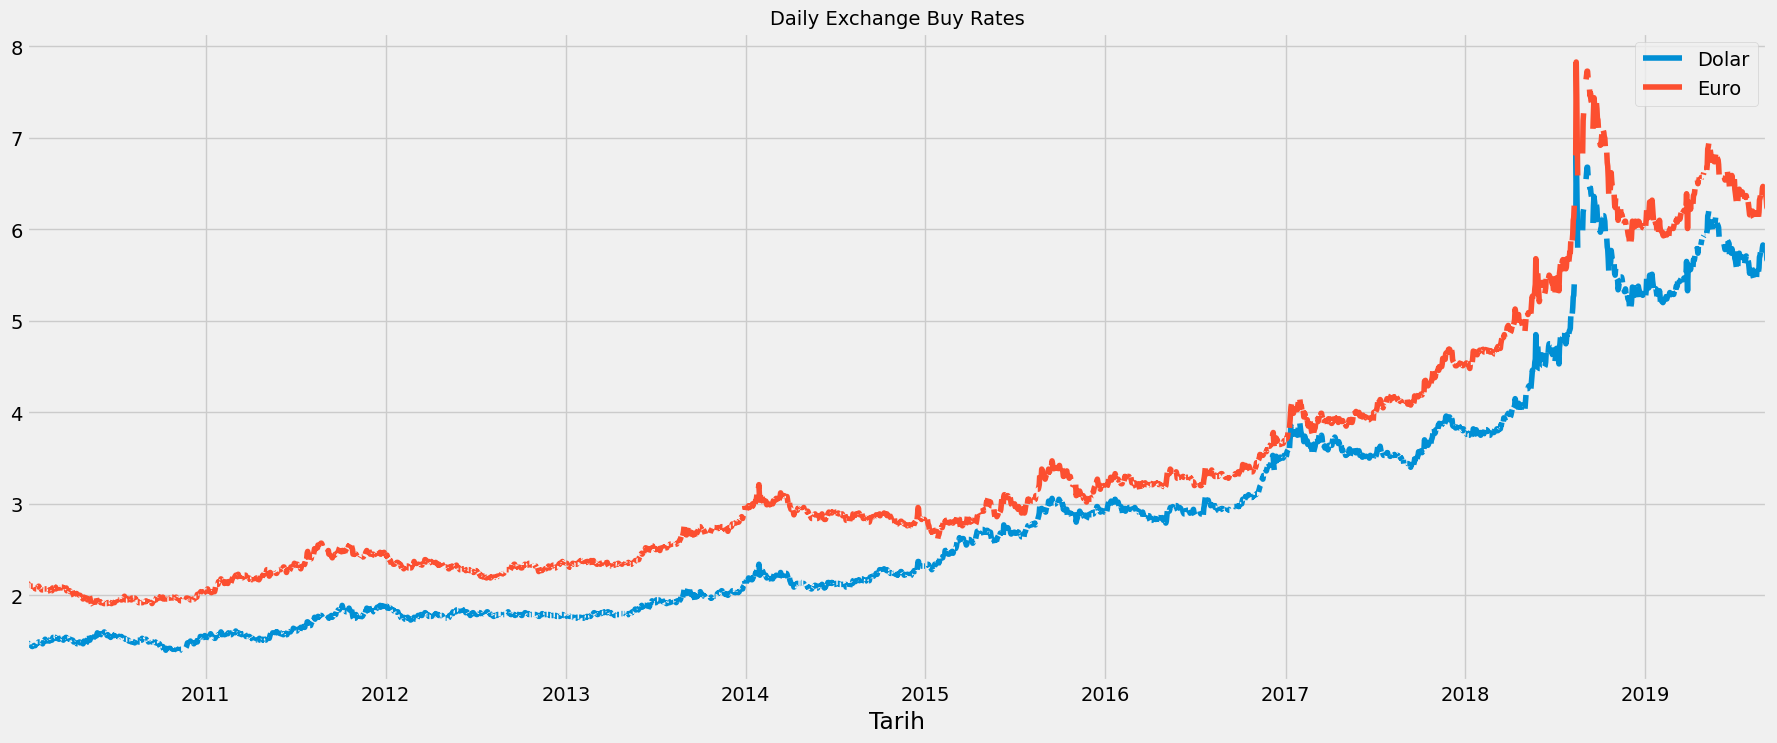

In [15]:
# Figurize orijinal data values
fig = plt.figure(figsize=(20,8))
df.Dolar.plot(label='Dolar')
df.Euro.plot(label='Euro')
plt.legend(loc='best')
plt.title('Daily Exchange Buy Rates', fontsize=14)
plt.show()

In [16]:
# Normalization and scaler values with some example for Dolar column
values = df['Dolar'].values.reshape(-1,1)
values = values.astype('float64')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset1 = scaler.fit_transform(values)
dataset1[0:5]

array([[0.01821494],
       [0.01639345],
       [0.01457196],
       [0.01457196],
       [0.01457196]])

In [20]:
# Normalization and scaler values with some example for Euro column
values = df['Euro'].values.reshape(-1,1)
values = values.astype('float64')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset2 = scaler.fit_transform(values)
dataset2[0:5]

array([[0.04208756],
       [0.04040406],
       [0.03872052],
       [0.03703702],
       [0.03703702]])

In [17]:
# Build Model
TRAIN_SIZE = 0.80
 
train_size1 = int(len(dataset1) * TRAIN_SIZE)
test_size1 = len(dataset1) - train_size1
train1, test1 = dataset1[0:train_size1, :], dataset1[train_size1:len(dataset1), :]
print("Number of Days (training set, test set): " + str((len(train1), len(test1))))

Number of Days (training set, test set): (2826, 707)


In [18]:
# For Dolar Colums, create using dataset with train set
def create_dataset1(dataset1, window_size = 1):
    data_X1, data_Y1 = [], []
    for i in range(len(dataset1) - window_size - 1):
        a = dataset1[i:(i + window_size), 0]
        data_X1.append(a)
        data_Y1.append(dataset1[i + window_size, 0])
    return(np.array(data_X1), np.array(data_Y1))

In [19]:
# Dolar data values are shaped and training
window_size = 1
train_X1, train_Y1 = create_dataset1(train1, window_size)
test_X1, test_Y1 = create_dataset1(test1, window_size)
print("Original training data shape:")
print(train_X1.shape)
 

train_X1 = np.reshape(train_X1, (train_X1.shape[0], 1, train_X1.shape[1]))
test_X1 = np.reshape(test_X1, (test_X1.shape[0], 1, test_X1.shape[1]))
print("New training data shape:")
print(train_X1.shape)

Original training data shape:
(2824, 1)
New training data shape:
(2824, 1, 1)


In [21]:
# Fit the model for Dolar data values
def fit_model1(train_X1, train_Y1, window_size = 1):
    model = Sequential()
    model.add(LSTM(100, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X1, 
              train_Y1, 
              epochs = 30, 
              batch_size = 1, 
              verbose = 1)
    
    return(model)
 

model1 = fit_model1(train_X1, train_Y1, window_size)


Epoch 1/30
2824/2824 [==============================] - 8s 2ms/step - loss: nan
Epoch 2/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 3/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 4/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 5/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 6/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 7/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 8/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 9/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 10/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 11/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 12/30
2824/2824 [==============================] - 6s 2ms/step - loss: nan
Epoch 13/30
2824/2824 [==============

In [22]:
# Find the prediction value with Dolar data values
def predict_and_score1(model1, X1, Y1):
   
    pred = scaler.inverse_transform(model1.predict(X1))
    orig_data = scaler.inverse_transform([Y1])
    
    score1 = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score1, pred)
 
rmse_train1, train_predict1 = predict_and_score1(model1, train_X1, train_Y1)
rmse_test1, test_predict1 = predict_and_score1(model1, test_X1, test_Y1)
 
print("Training data score: %.2f RMSE" % rmse_train1)
print("Test data score: %.2f RMSE" % rmse_test1)

#The graphic drawn with prediction and orijinal data values for Dolar column
train_predict_plot1 = np.empty_like(dataset1)
train_predict_plot1[:, :] = np.nan
train_predict_plot1[window_size:len(train_predict1) + window_size, :] = train_predict1
 

test_predict_plot1 = np.empty_like(dataset1)
test_predict_plot1[:, :] = np.nan
test_predict_plot1[len(train_predict1) + (window_size * 2) + 1:len(dataset1) - 1, :] = test_predict1

plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset1), label = "True value")
plt.plot(train_predict_plot1, label = "Training set prediction")
plt.plot(test_predict_plot1, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Exchange Rates")
plt.title("Comparison true vs. predicted training / test Dolar")
plt.legend()
plt.show()

89/89 [==============================] - 1s 2ms/step


ValueError: Input contains NaN.

In [ ]:
# The same way for Euro column with Euro data values, build some model
train_size2 = int(len(dataset2) * TRAIN_SIZE)
test_size2 = len(dataset2) - train_size2
train2, test2 = dataset2[0:train_size2, :], dataset1[train_size2:len(dataset2), :]
print("Number of Days (training set, test set): " + str((len(train2), len(test2))))

In [ ]:
# For Dolar Colums, create using dataset with train set
def create_dataset2(dataset2, window_size = 1):
    data_X2, data_Y2 = [], []
    for i in range(len(dataset2) - window_size - 1):
        a = dataset2[i:(i + window_size), 0]
        data_X2.append(a)
        data_Y2.append(dataset2[i + window_size, 0])
    return(np.array(data_X2), np.array(data_Y2))

In [ ]:
# Euro data values are shaped and training
window_size = 1
train_X2, train_Y2 = create_dataset2(train2, window_size)
test_X2, test_Y2 = create_dataset2(test2, window_size)
print("Original training data shape:")
print(train_X2.shape)
 

train_X2 = np.reshape(train_X2, (train_X2.shape[0], 1, train_X2.shape[1]))
test_X2 = np.reshape(test_X2, (test_X2.shape[0], 1, test_X2.shape[1]))
print("New training data shape:")
print(train_X2.shape)

In [ ]:
# Fit the model for Euro data values

def fit_model2(train_X2, train_Y2, window_size = 1):
    model = Sequential()
   
    model.add(LSTM(100, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
  
    model.fit(train_X2, 
              train_Y2, 
              epochs = 30, 
              batch_size = 1, 
              verbose = 1)
    
    return(model)
model2 = fit_model(train_X2, train_Y2, window_size)


In [ ]:
# Find the prediction value with Euro data values
def predict_and_score2(model2, X2, Y2):
   
    pred = scaler.inverse_transform(model.predict(X2))
    orig_data = scaler.inverse_transform([Y2])
    
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)
 
rmse_train2, train_predict2 = predict_and_score(model2, train_X2, train_Y2)
rmse_test2, test_predict2 = predict_and_score(model2, test_X2, test_Y2)
 
print("Training data score: %.2f RMSE" % rmse_train2)
print("Test data score: %.2f RMSE" % rmse_test2)

In [ ]:
#The graphic drawn with prediction and orijinal data values for Euro column    
    
train_predict_plot2 = np.empty_like(dataset2)
train_predict_plot2[:, :] = np.nan
train_predict_plot2[window_size:len(train_predict2) + window_size, :] = train_predict2
 

test_predict_plot2 = np.empty_like(dataset2)
test_predict_plot2[:, :] = np.nan
test_predict_plot2[len(train_predict2) + (window_size * 2) + 1:len(dataset2) - 1, :] = test_predict2

plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset2), label = "True value")
plt.plot(train_predict_plot2, label = "Training set prediction")
plt.plot(test_predict_plot2, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Exchange Rates")
plt.title("Comparison true vs. predicted training / test  Euro")
plt.legend()
plt.show()
